<h1 style="text-align: center">
Deep Learning HW3 </br>
VAE and CVAE
</h1>


### Full Name: Sara Karimi
### Student ID: 401011151

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

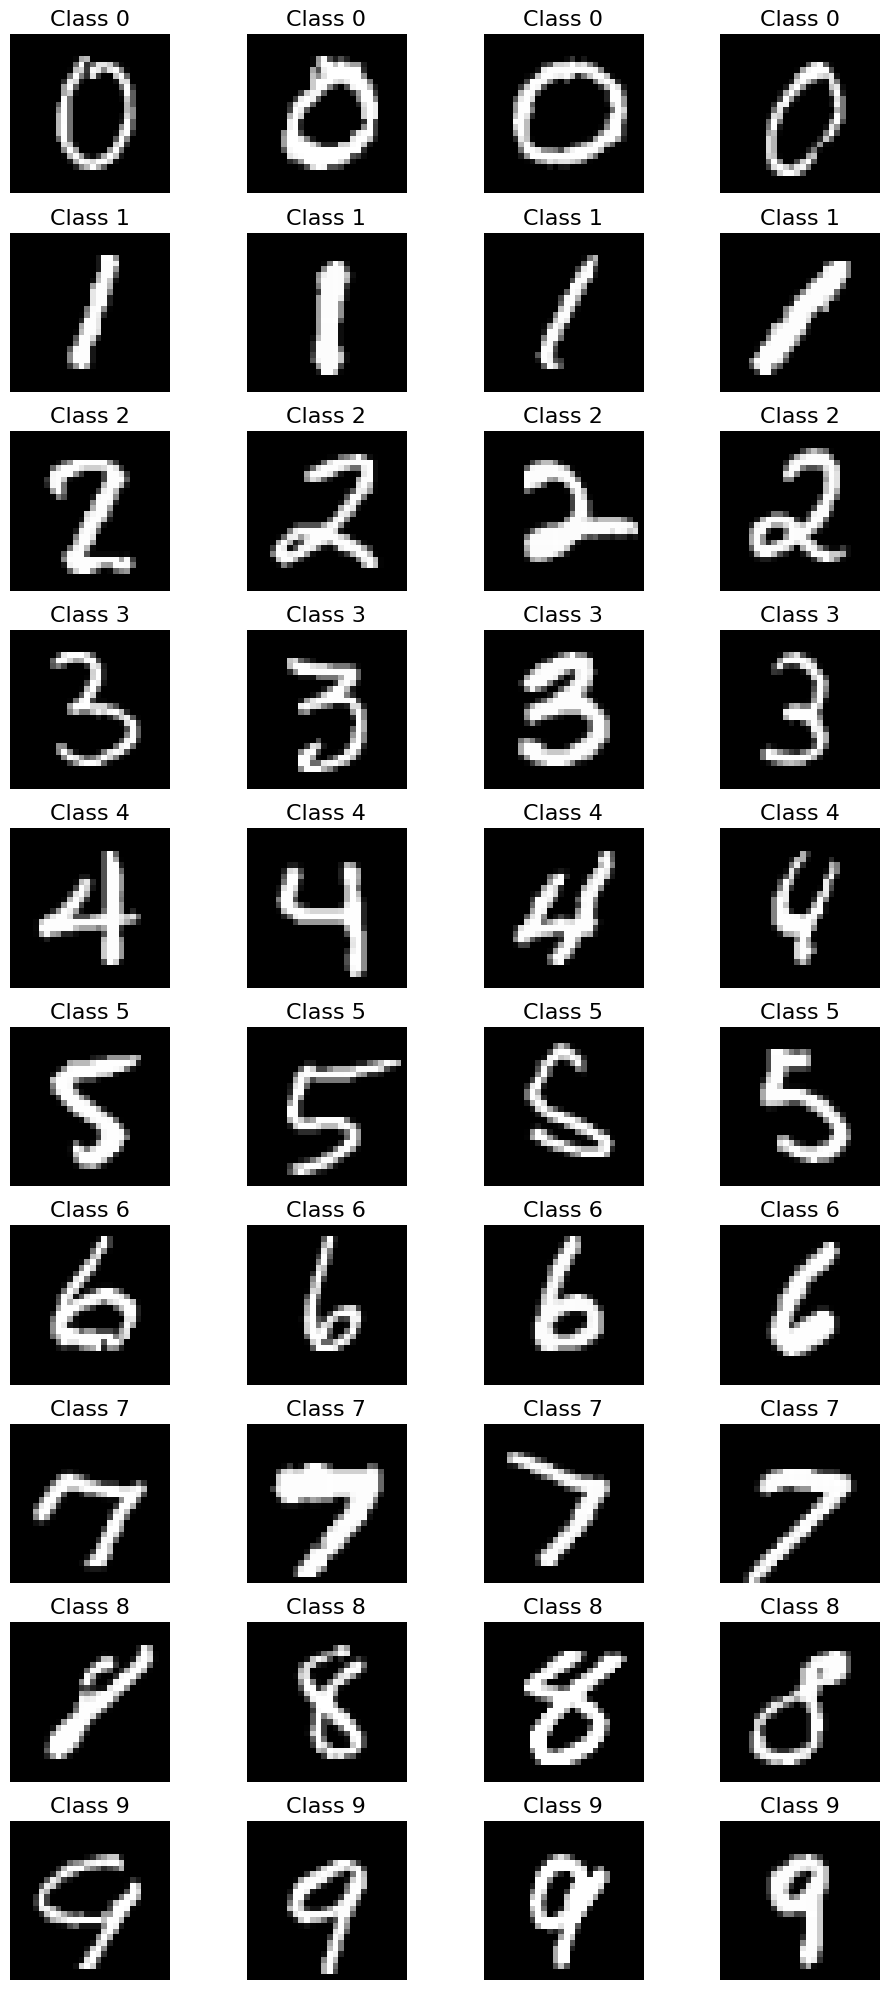

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        return mu + torch.exp(logvar / 2) * torch.randn_like(mu).to(device)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(recon, data.view(-1, 784), reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + kl_divergence

In [9]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            recon, mu, logvar = model(data)

            data = data.view(data.size(0), -1)
            recon = recon.view(recon.size(0), -1)

            loss = vae_loss(recon, data, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 5 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model
            torch.save(best_model.state_dict(), 'best_vae_mlp_model.pth')

    model.load_state_dict(torch.load('best_vae_mlp_model.pth'))
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/30], Loss: 172.07350876464844

##################################################
VAE-MLP Epoch [2/30], Loss: 154.44935750325521

##################################################
VAE-MLP Epoch [3/30], Loss: 149.8258345621745

##################################################
VAE-MLP Epoch [4/30], Loss: 147.1601035888672

##################################################
VAE-MLP Epoch [5/30], Loss: 145.55301013997396
Sample Images:


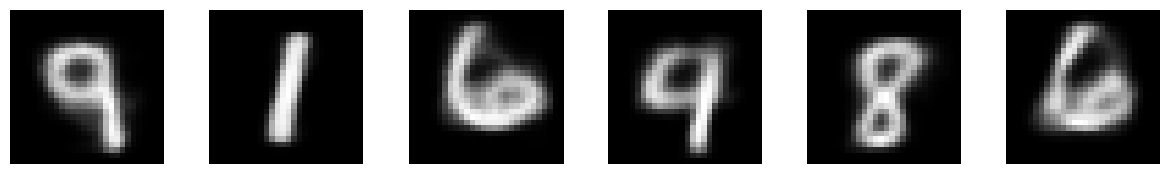


##################################################
VAE-MLP Epoch [6/30], Loss: 144.65800848795573

##################################################
VAE-MLP Epoch [7/30], Loss: 143.5008443359375

##################################################
VAE-MLP Epoch [8/30], Loss: 142.47321129557292

##################################################
VAE-MLP Epoch [9/30], Loss: 142.03590458170572

##################################################
VAE-MLP Epoch [10/30], Loss: 141.27520855305988
Sample Images:


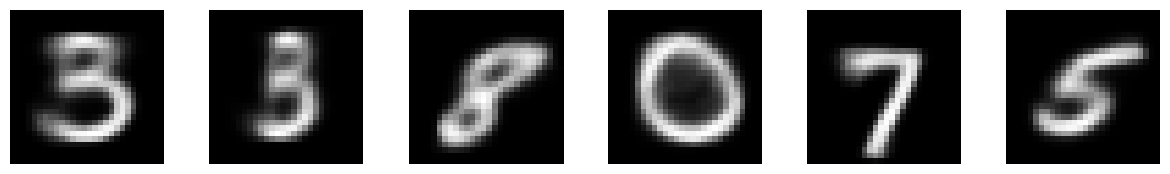


##################################################
VAE-MLP Epoch [11/30], Loss: 141.04943755696615

##################################################
VAE-MLP Epoch [12/30], Loss: 140.4382071940104

##################################################
VAE-MLP Epoch [13/30], Loss: 139.97814196777344

##################################################
VAE-MLP Epoch [14/30], Loss: 139.66775696207682

##################################################
VAE-MLP Epoch [15/30], Loss: 139.34296945800781
Sample Images:


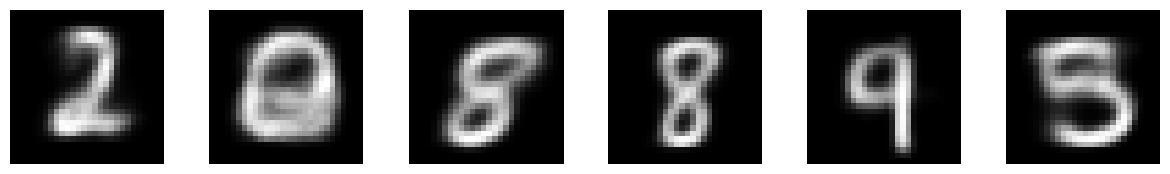


##################################################
VAE-MLP Epoch [16/30], Loss: 139.18532899576823

##################################################
VAE-MLP Epoch [17/30], Loss: 139.0577993326823

##################################################
VAE-MLP Epoch [18/30], Loss: 138.67962614746094

##################################################
VAE-MLP Epoch [19/30], Loss: 138.41071731770833

##################################################
VAE-MLP Epoch [20/30], Loss: 138.49130681152343
Sample Images:


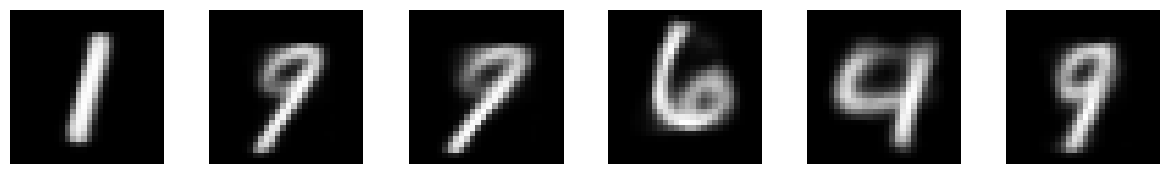


##################################################
VAE-MLP Epoch [21/30], Loss: 138.0847303466797

##################################################
VAE-MLP Epoch [22/30], Loss: 137.9421491455078

##################################################
VAE-MLP Epoch [23/30], Loss: 137.76146407877604

##################################################
VAE-MLP Epoch [24/30], Loss: 137.3792077311198

##################################################
VAE-MLP Epoch [25/30], Loss: 137.2883357421875
Sample Images:


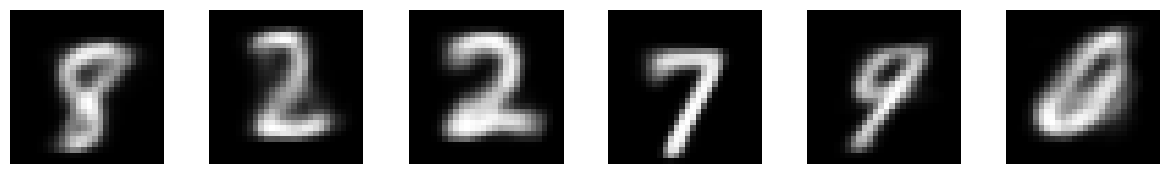


##################################################
VAE-MLP Epoch [26/30], Loss: 137.10167475585936

##################################################
VAE-MLP Epoch [27/30], Loss: 136.93984568684897

##################################################
VAE-MLP Epoch [28/30], Loss: 136.90390568033854

##################################################
VAE-MLP Epoch [29/30], Loss: 136.63330729573568

##################################################
VAE-MLP Epoch [30/30], Loss: 136.48937724609374
Sample Images:


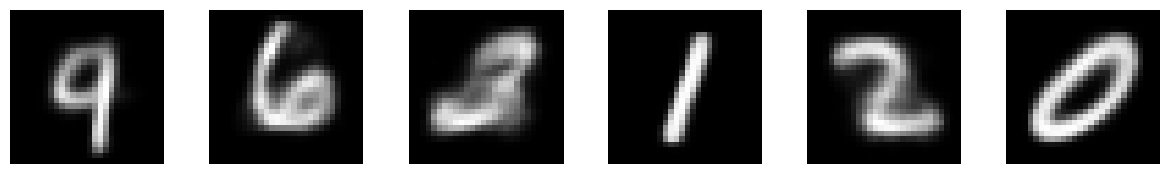

Best model saved as 'best_vae_mlp_model.pth'


In [10]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=512, latent_dim=2).to(device)
train_vae_mlp(vae_mlp, train_loader, num_epochs=30, learning_rate=1e-3)

# 2) CVAE --> MLP

In [11]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        return mu + torch.exp(logvar / 2) * torch.randn_like(mu).to(device)

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        dec_input = torch.cat([z, y], dim=1)
        reconstructed = self.decoder(dec_input)

        return reconstructed, mu, logvar, class_logits


In [12]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    data = data.view(data.size(0), -1)

    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    return reconstruction_loss + kl_divergence + ce_loss


In [13]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)

            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 5 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1).to(device)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model
            torch.save(best_model.state_dict(), 'best_cvae_mlp_model.pth')


    model.load_state_dict(torch.load('best_cvae_mlp_model.pth'))
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/30], Loss: 154.35603798828126

##################################################
CVAE-MLP Epoch [2/30], Loss: 136.1083866373698

##################################################
CVAE-MLP Epoch [3/30], Loss: 133.3530019042969

##################################################
CVAE-MLP Epoch [4/30], Loss: 132.1530637125651

##################################################
CVAE-MLP Epoch [5/30], Loss: 131.24016607259114
Sample Images:


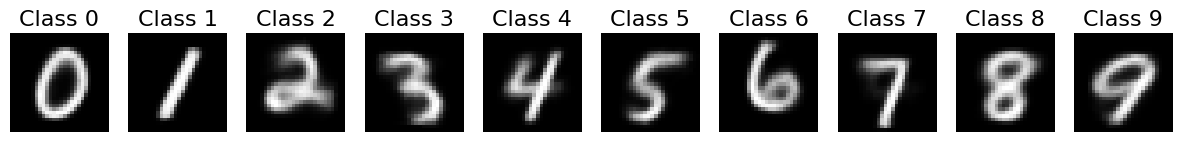


##################################################
CVAE-MLP Epoch [6/30], Loss: 130.56109989420574

##################################################
CVAE-MLP Epoch [7/30], Loss: 130.06186110432944

##################################################
CVAE-MLP Epoch [8/30], Loss: 129.57822408040366

##################################################
CVAE-MLP Epoch [9/30], Loss: 129.14562014160157

##################################################
CVAE-MLP Epoch [10/30], Loss: 128.82322467447918
Sample Images:


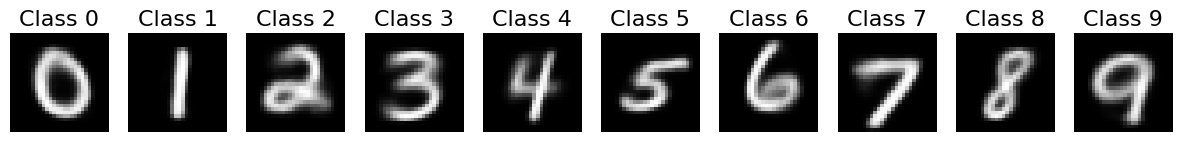


##################################################
CVAE-MLP Epoch [11/30], Loss: 128.45731881917317

##################################################
CVAE-MLP Epoch [12/30], Loss: 128.16318994547527

##################################################
CVAE-MLP Epoch [13/30], Loss: 127.860257421875

##################################################
CVAE-MLP Epoch [14/30], Loss: 127.55893087565104

##################################################
CVAE-MLP Epoch [15/30], Loss: 127.43465458170573
Sample Images:


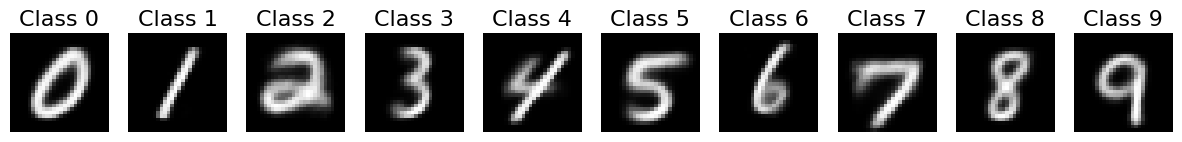


##################################################
CVAE-MLP Epoch [16/30], Loss: 127.11250466308594

##################################################
CVAE-MLP Epoch [17/30], Loss: 126.8932230834961

##################################################
CVAE-MLP Epoch [18/30], Loss: 126.55878700764974

##################################################
CVAE-MLP Epoch [19/30], Loss: 126.4806451578776

##################################################
CVAE-MLP Epoch [20/30], Loss: 126.33507553304037
Sample Images:


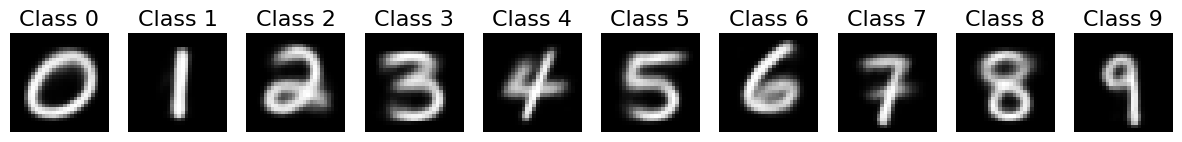


##################################################
CVAE-MLP Epoch [21/30], Loss: 126.12099683430989

##################################################
CVAE-MLP Epoch [22/30], Loss: 125.99137364908854

##################################################
CVAE-MLP Epoch [23/30], Loss: 125.76462114664713

##################################################
CVAE-MLP Epoch [24/30], Loss: 125.6276927734375

##################################################
CVAE-MLP Epoch [25/30], Loss: 125.44519931640625
Sample Images:


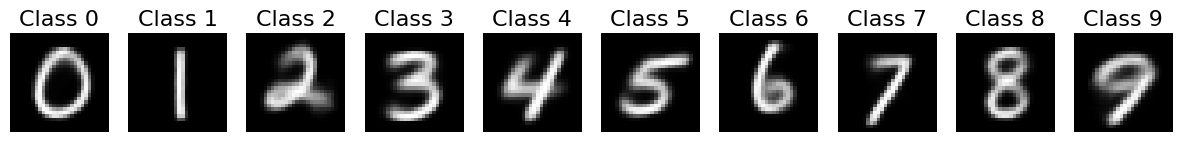


##################################################
CVAE-MLP Epoch [26/30], Loss: 125.3145157796224

##################################################
CVAE-MLP Epoch [27/30], Loss: 125.16674419352213

##################################################
CVAE-MLP Epoch [28/30], Loss: 125.06534975585937

##################################################
CVAE-MLP Epoch [29/30], Loss: 124.85554106852213

##################################################
CVAE-MLP Epoch [30/30], Loss: 124.79352819824219
Sample Images:


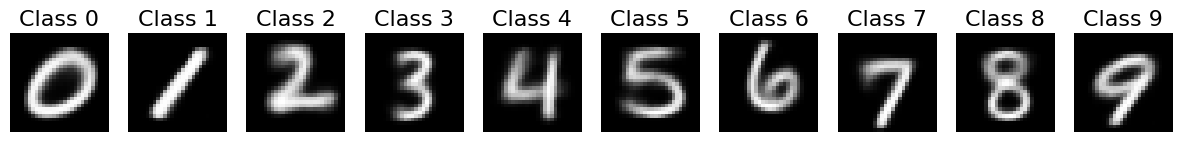

Best model saved as 'best_cvae_mlp_model.pth'


In [14]:
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=512, latent_dim=2, num_classes=10).to(device)
train_cvae_mlp(cvae_mlp, train_loader, num_epochs=30)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


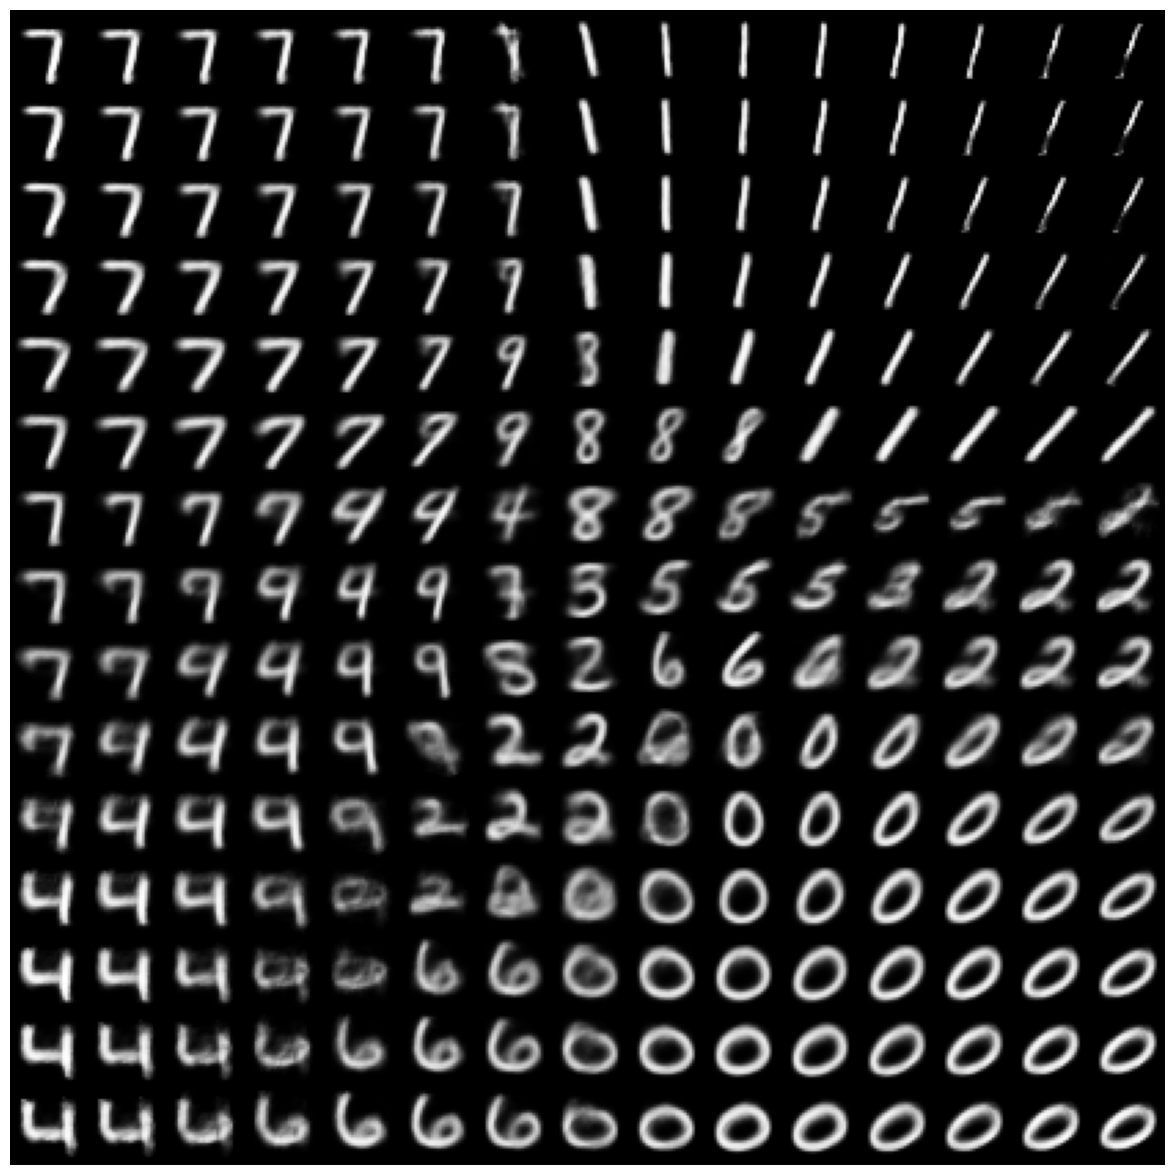

In [27]:
def plot_latent_vae(model, x_range, y_range, num_samples=10):
    x = np.linspace(*x_range, num_samples)
    y = np.linspace(*y_range, num_samples)
    image = np.empty((28 * num_samples, 28 * num_samples))
    for i, yi in enumerate(x):
        for j, xi in enumerate(y):
            z = torch.tensor([xi, yi]).float().to(device)
            x_hat = model.decoder(z)
            image[(num_samples - 1 - i) * 28: (num_samples - i) * 28, j * 28: (j + 1) * 28] = x_hat.squeeze().cpu().detach().numpy().reshape(28, 28)
    plt.figure(figsize=(num_samples, num_samples))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

plot_latent_vae(vae_mlp, [-3, 3], [-3, 3], 15)

0, 1, 4, 7 are plotted in the corners and are generated very sharply in the training process.

2, 6 is plotted multiple times around 0.

9 is 4 becoming 7.

3 and 5 are not plotted sharply and are close to 8.

the whole distribution feels circular and rotations of 1, 7, 0 and 4 confirms this and point towards or around the center of distribution which is 0, 0

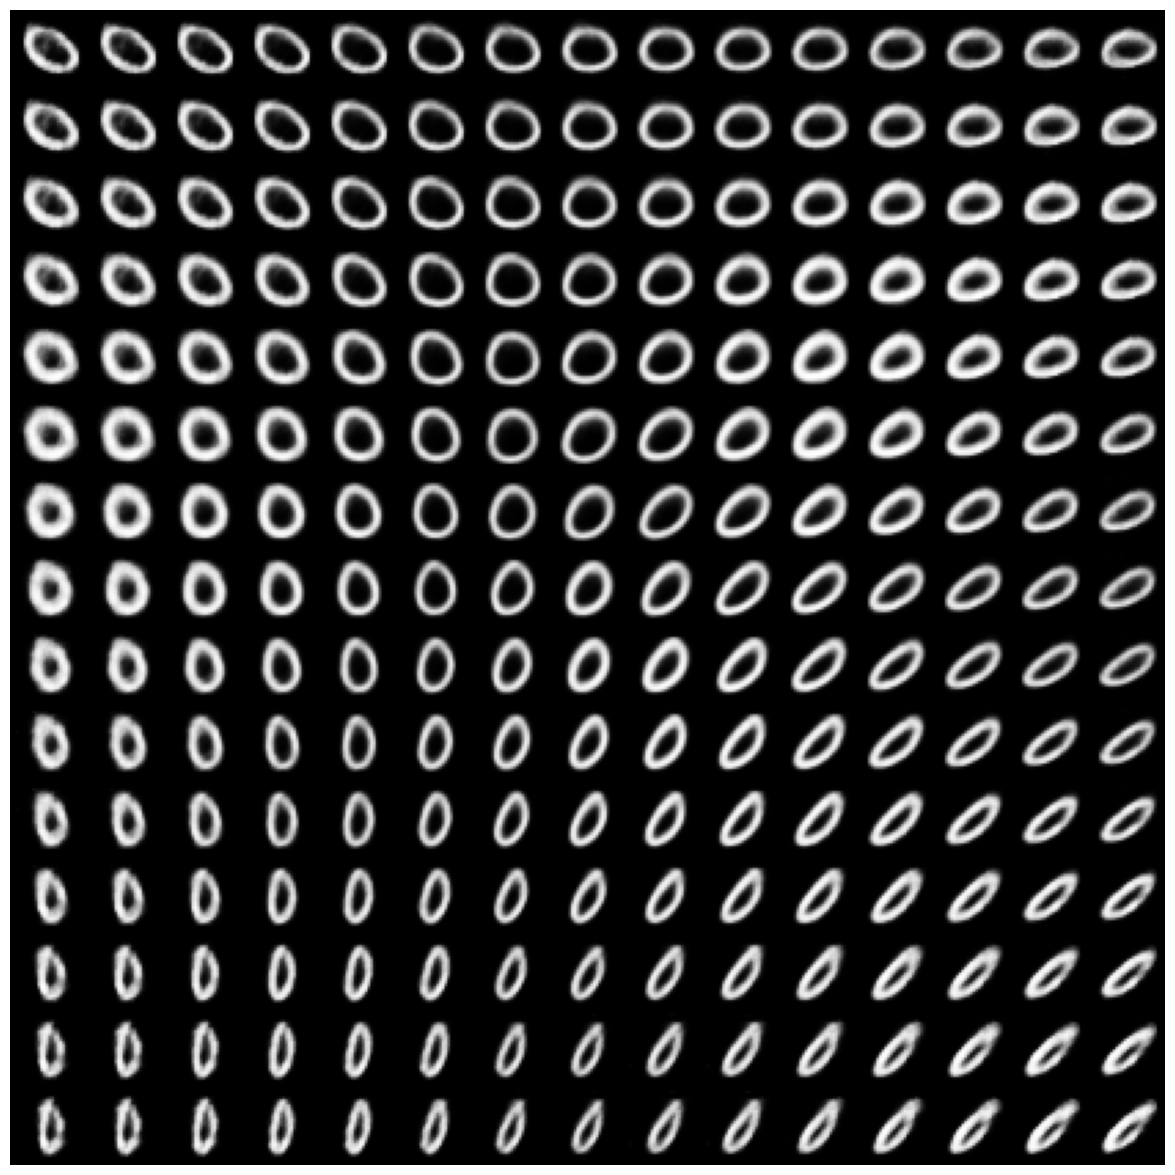

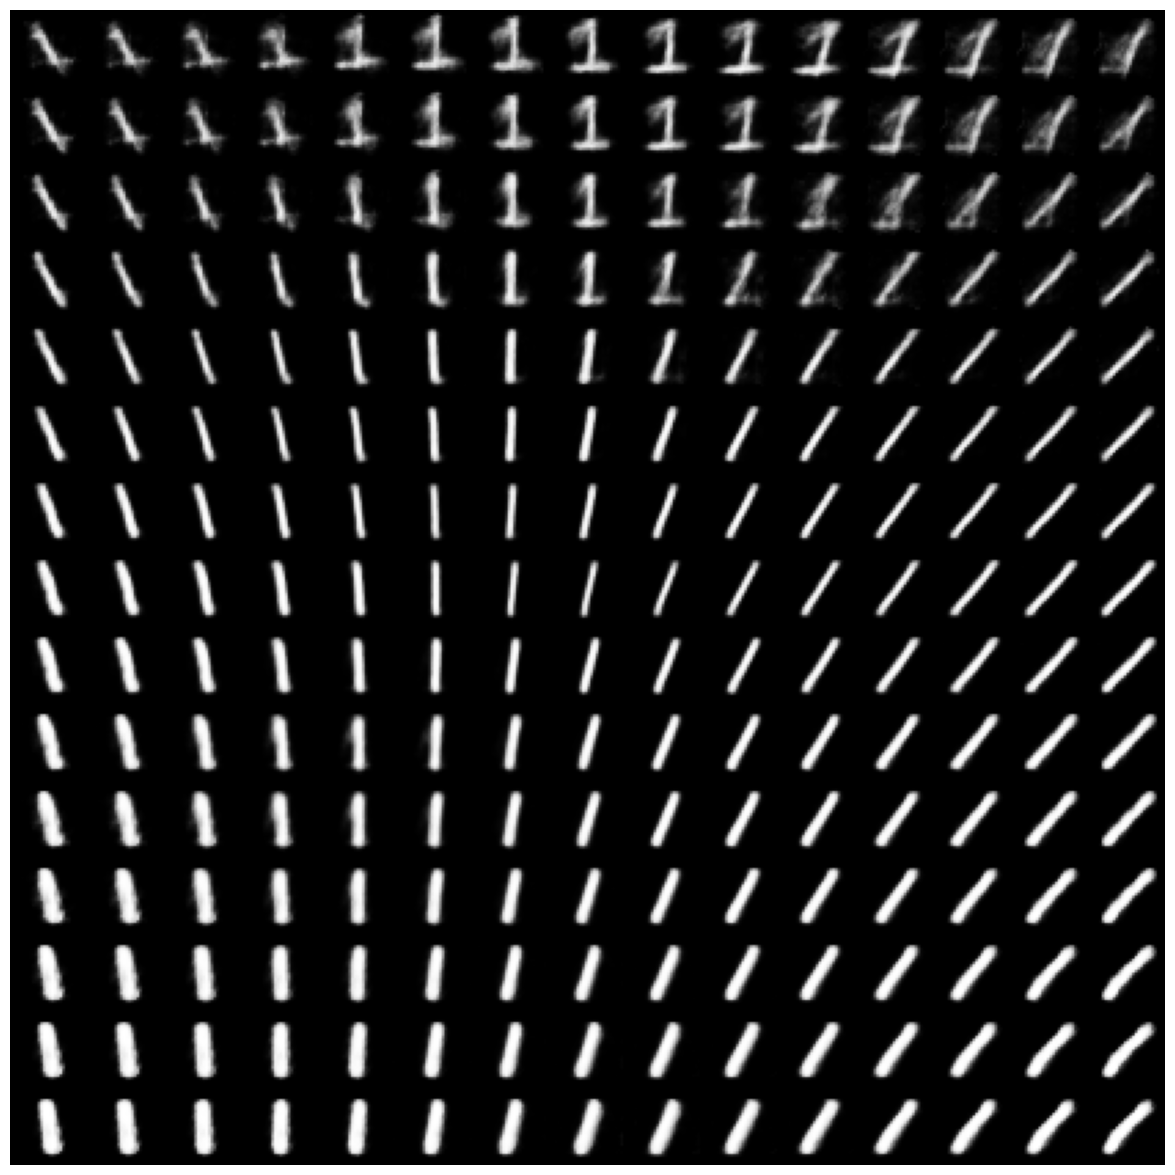

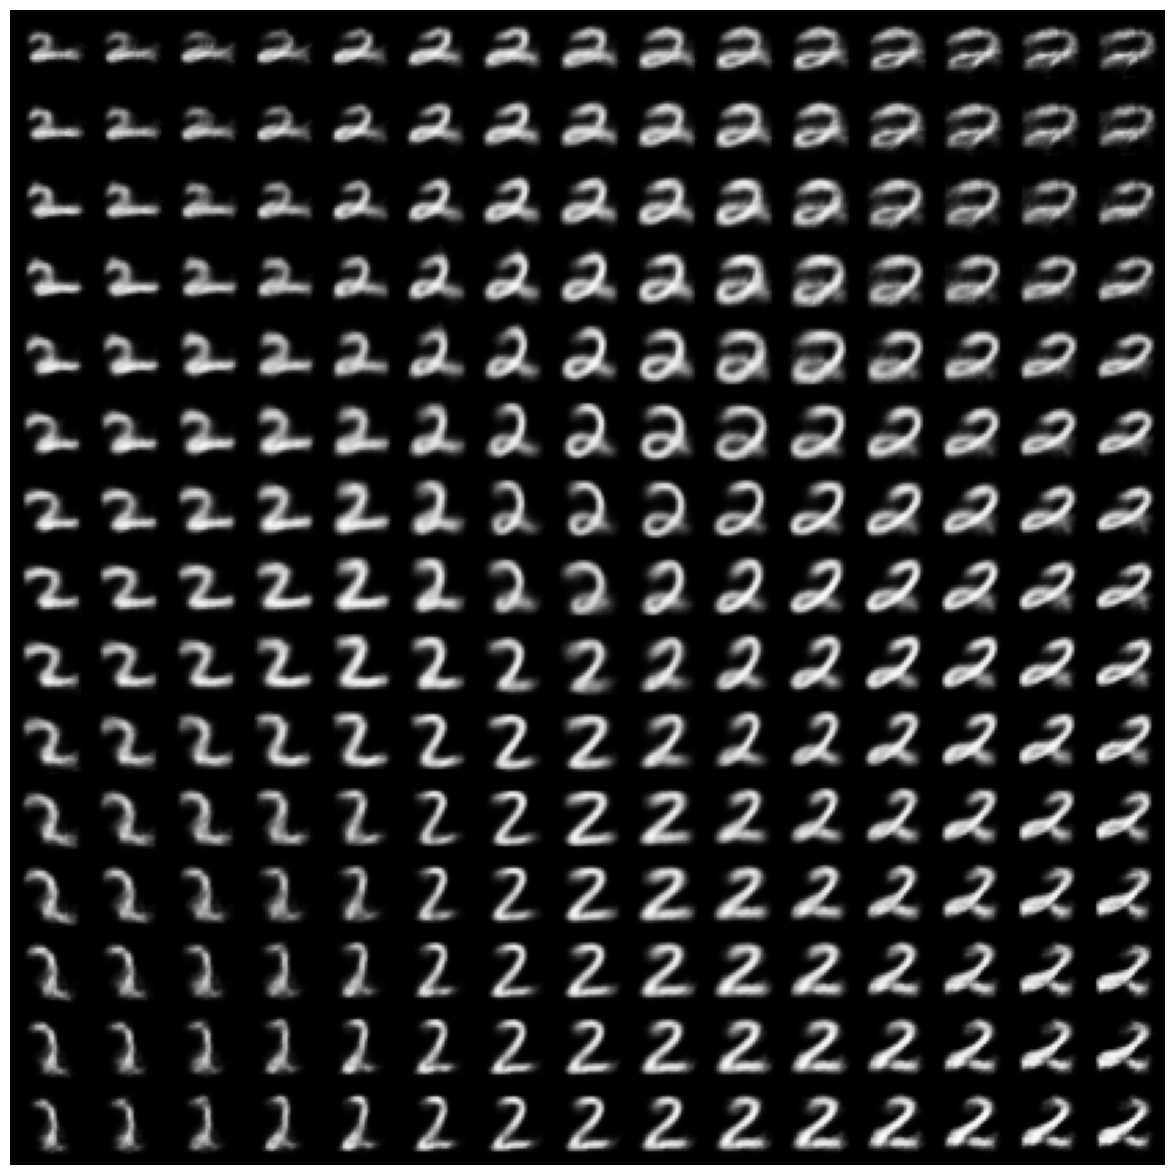

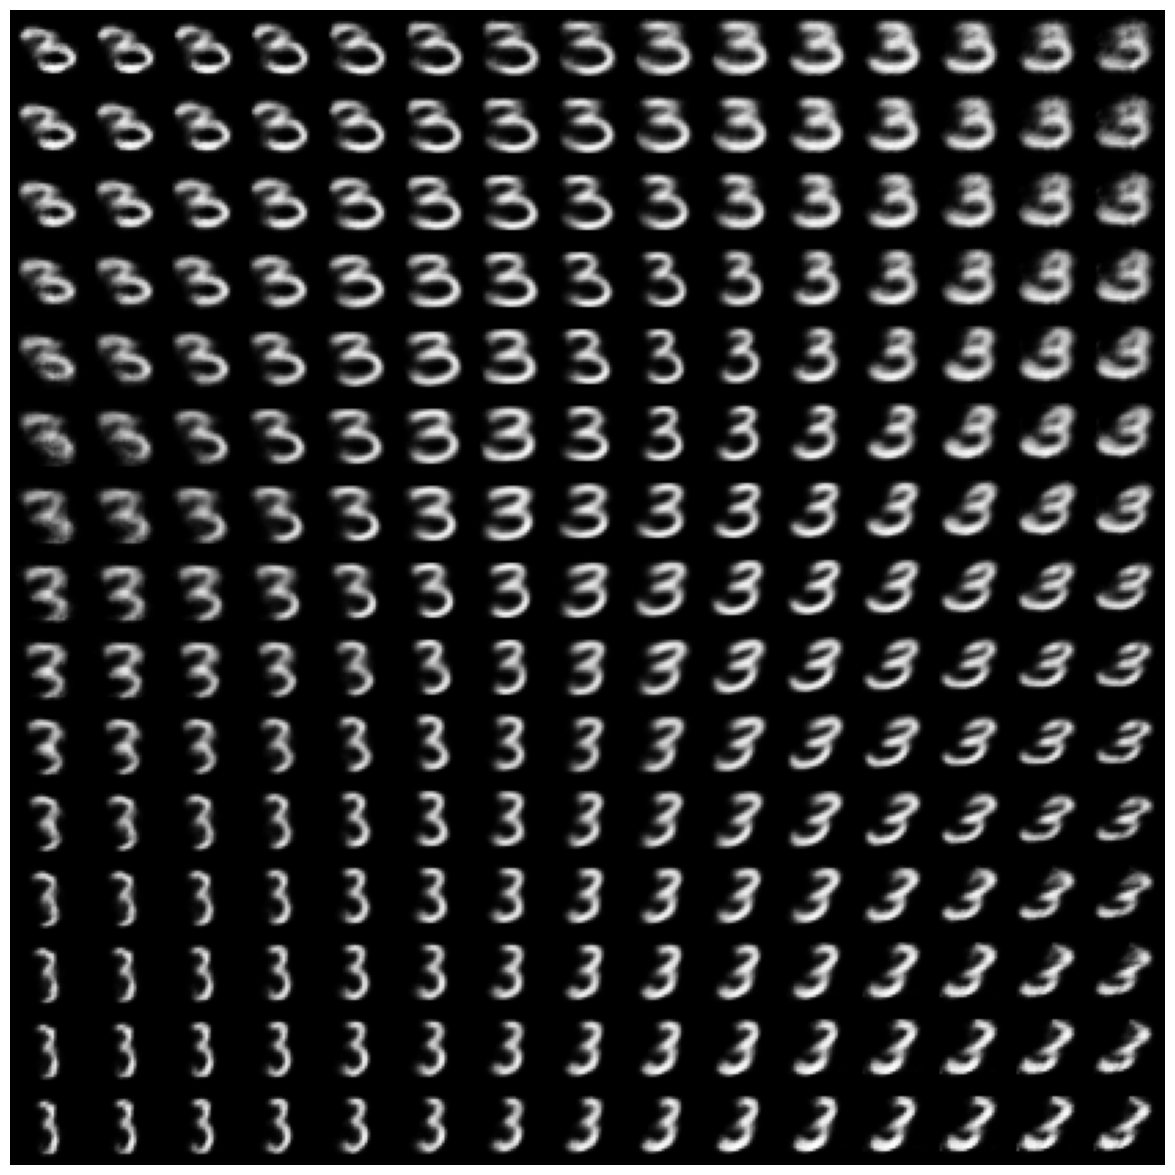

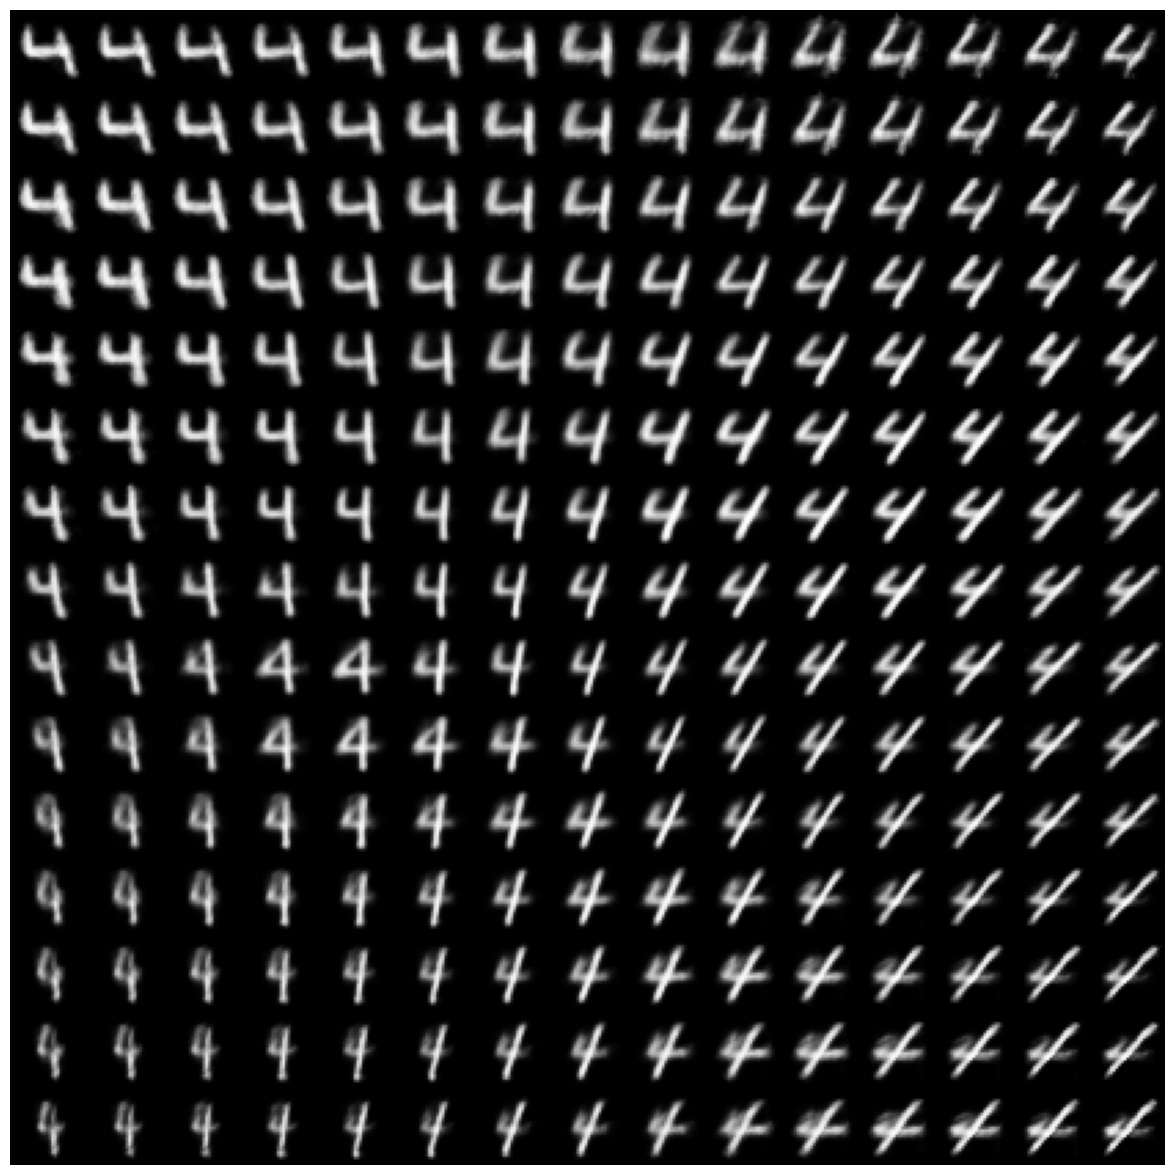

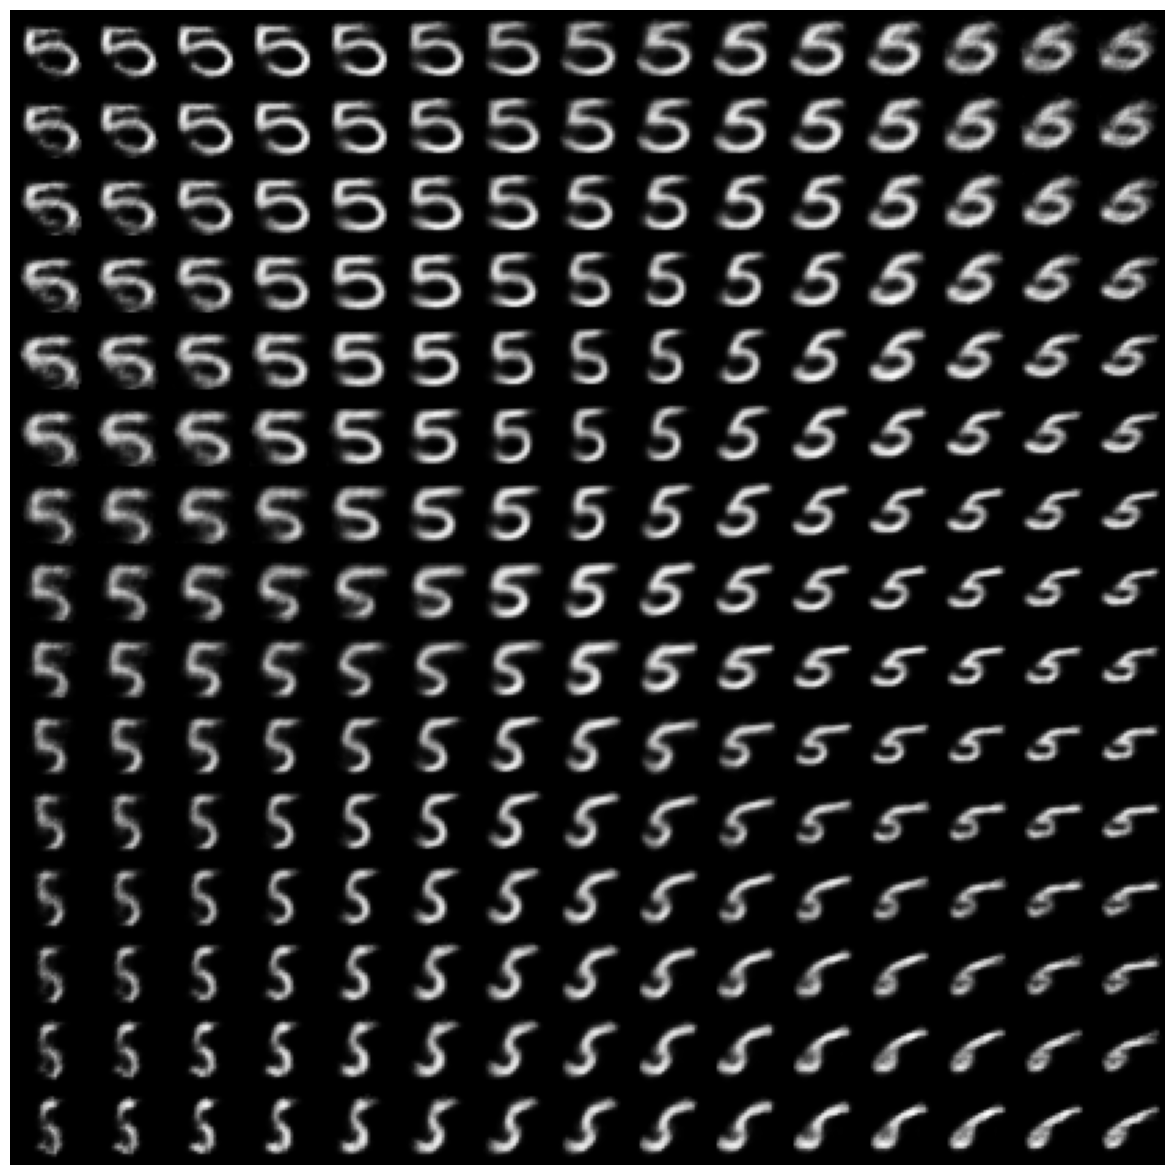

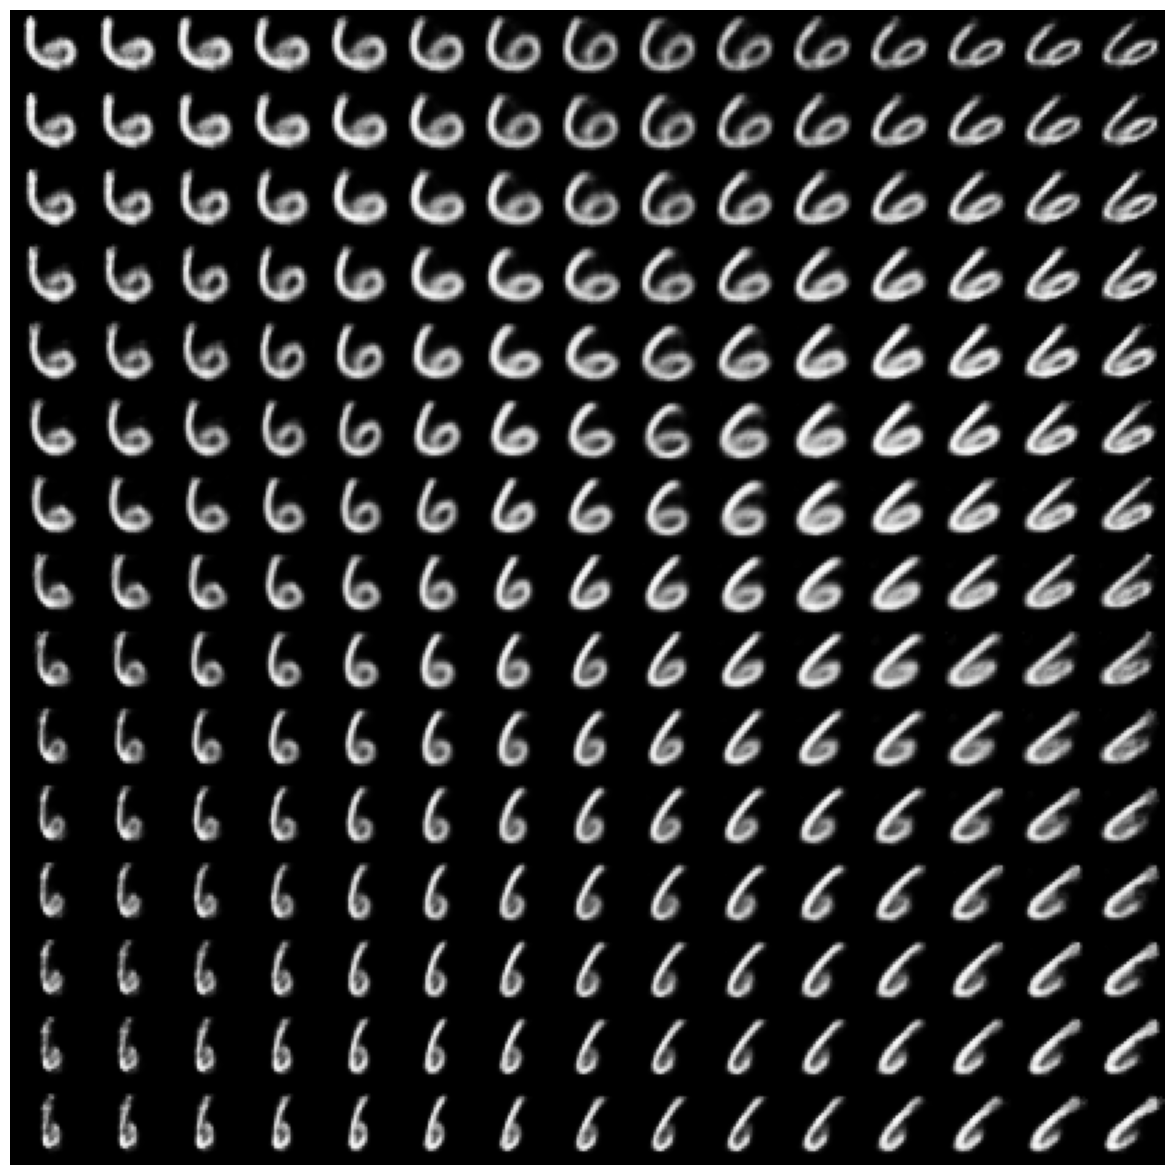

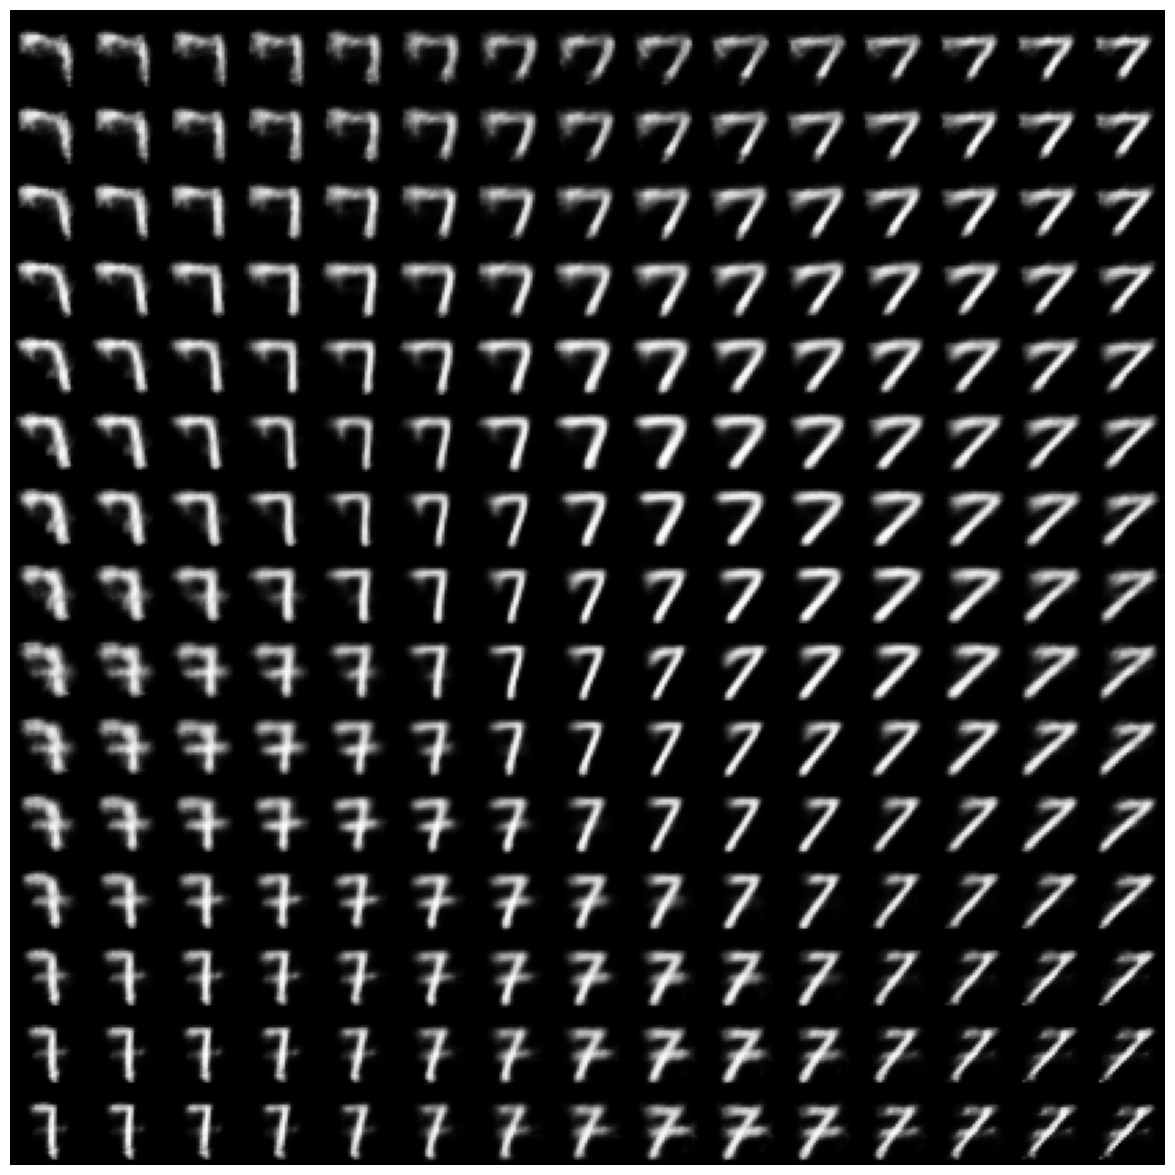

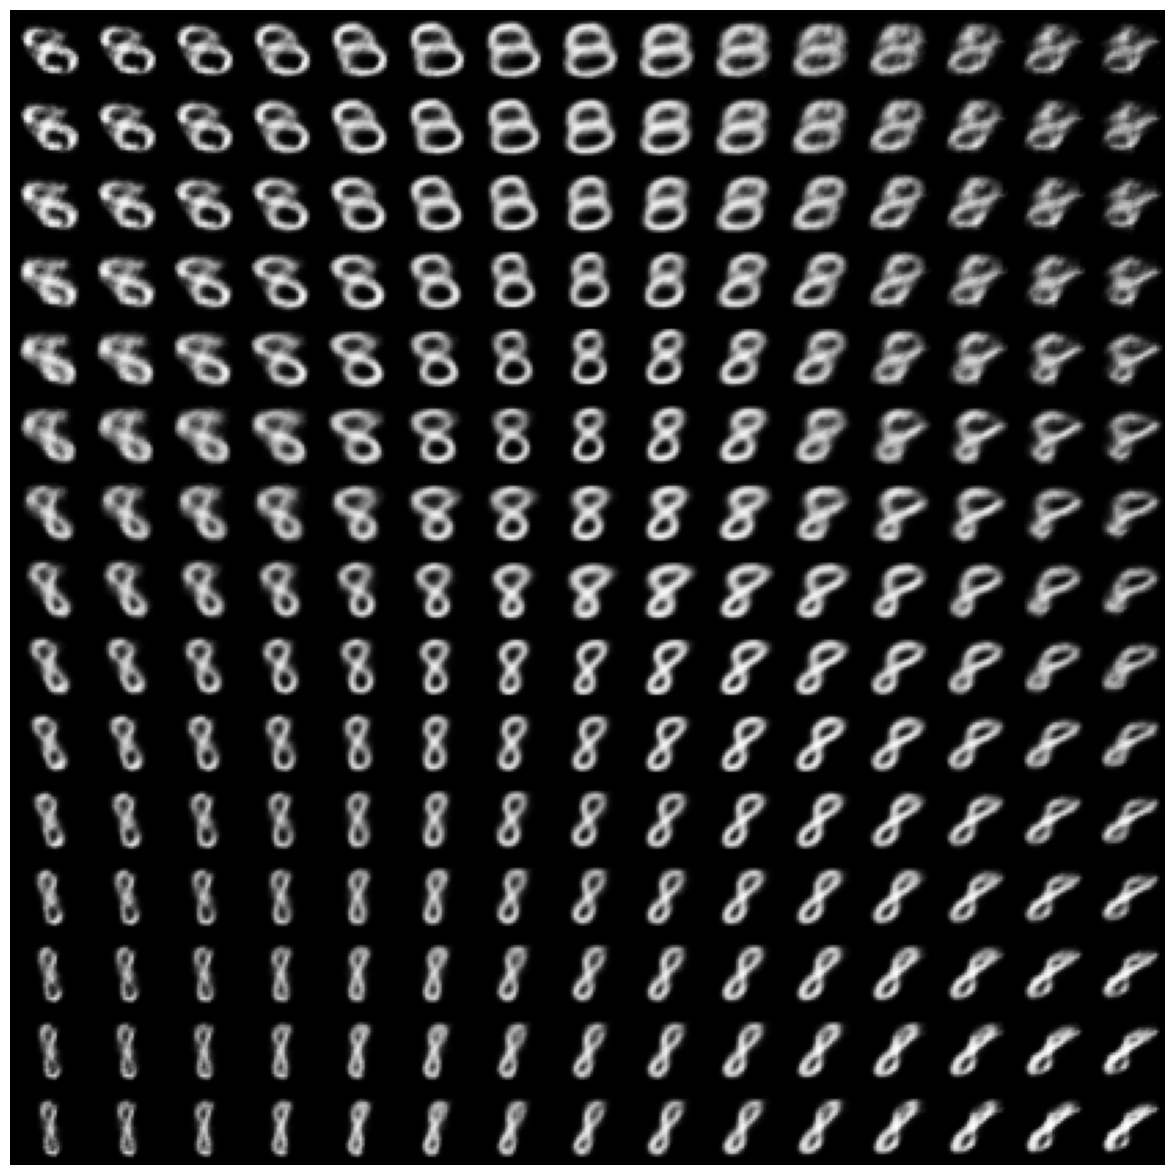

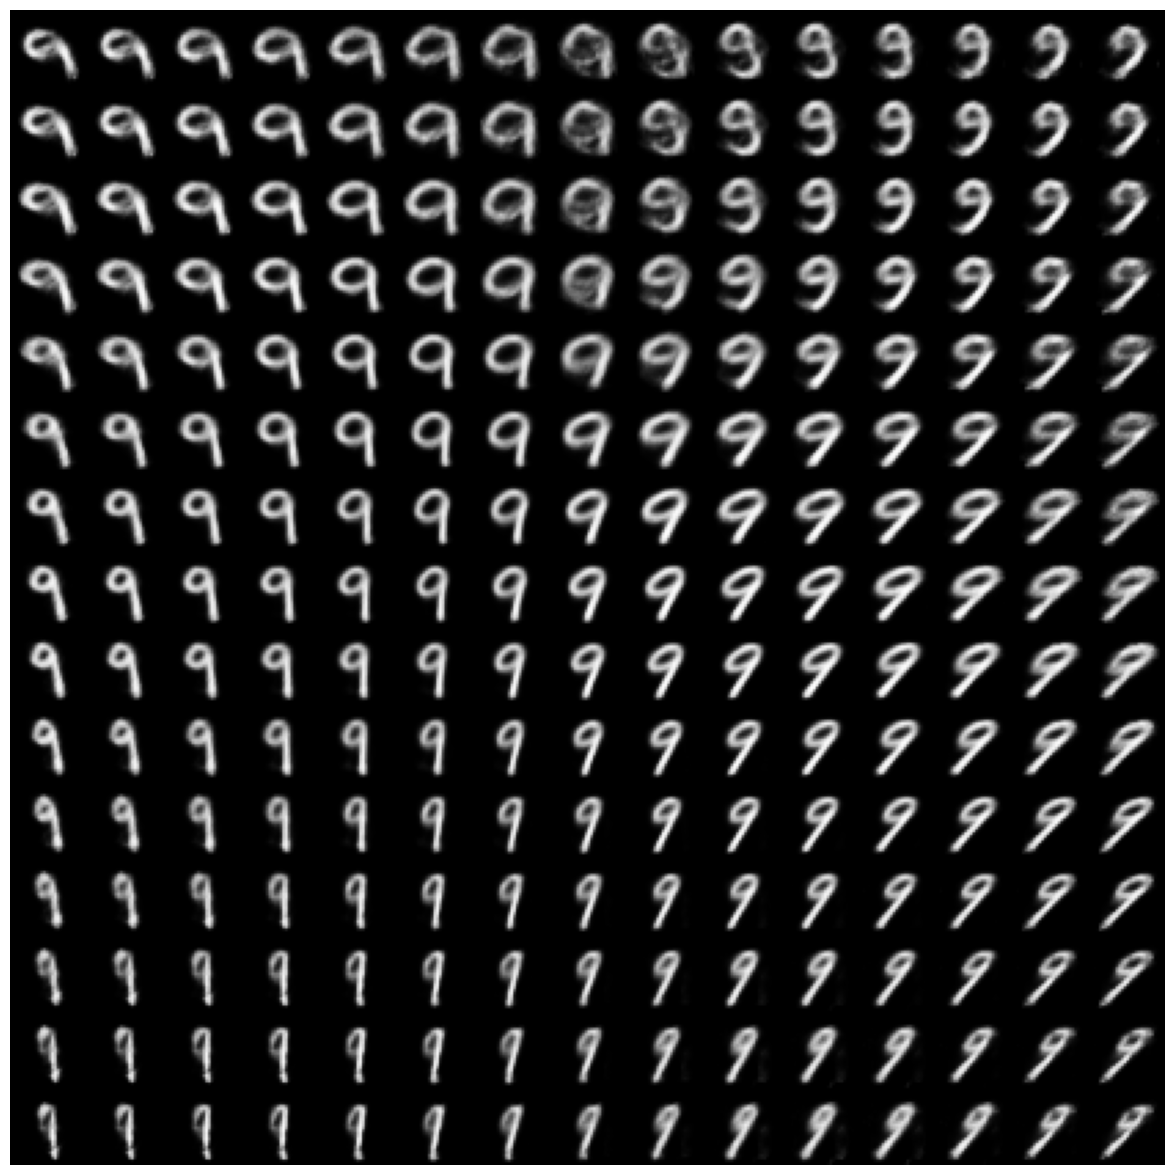

In [32]:
def plot_latent_cvae(model, cls, x_range, y_range, num_samples=10):
    x = np.linspace(*x_range, num_samples)
    y = np.linspace(*y_range, num_samples)
    image = np.empty((28 * num_samples, 28 * num_samples))
    for i, yi in enumerate(x):
        for j, xi in enumerate(y):
            z = torch.tensor([xi, yi]).float().to(device)
            label = F.one_hot(torch.tensor([cls]), num_classes=10).float().squeeze(0).to(device)
            x_hat = model.decoder(torch.cat([z, label], dim=0))
            image[(num_samples - 1 - i) * 28: (num_samples - i) * 28, j * 28: (j + 1) * 28] = x_hat.squeeze().cpu().detach().numpy().reshape(28, 28)
    plt.figure(figsize=(num_samples, num_samples))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

for cls in range(10):
    plot_latent_cvae(cvae_mlp, cls, [-3, 3], [-3, 3], 15)

center of distribution are where the numbers are plotted sharply and clearly and the orientation is the most normal.

2, 3, 8 are not plotted sharply. others are mostly fine.

distribution is still circular but the center is not 0, 0 anymore for all numbers.

CVAE latent space is less dense and has much more space between numbers with a better variance.